In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import time
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_csv(file_path):
    try:
        df = pd.read_csv(file_path, sep=";")
        print(df.shape)
        if df.empty:
            print("The CSV file is empty.")
            return None
        return df
    except pd.errors.EmptyDataError:
        print("No data in the CSV file.")
        return None
    except pd.errors.ParserError:
        print("Error parsing the CSV file.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [3]:
def get_loaded_camera_matrices(camera_path):
    with open(camera_path, 'r') as f:
        loaded_data = json.load(f)
        K_loaded = np.array(loaded_data['K'])
        RT_loaded = np.array(loaded_data['RT'])
        resx = int(loaded_data['resolution_x'])
        resy = int(loaded_data['resolution_y'])

    return resx, resy, K_loaded, RT_loaded

In [4]:
def get_point_cloud(file_path, noise = False):
    df = load_csv(file_path)
    if noise: coord = ['X', 'Y', 'Z']
    else: coord = ['X_noise', 'Y_noise', 'Z_noise']

    points = df[coord].values
    colors = df[['red', 'green', 'blue']].values

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    return point_cloud

In [5]:
def compute_projection_matrix(icm, ecm):
    """
    Compute the projection matrix P from intrinsic matrix icm and extrinsic matrix ecm.

    Parameters:
    - icm: Intrinsic matrix (3x3 numpy array)
    - ecm: Extrinsic matrix (4x4 numpy array)

    Returns:
    - P: Projection matrix (3x4 numpy array)
    """

    R = ecm[:3, :3] 
    t = ecm[:3, 3].reshape(-1, 1)

    # Compute projection matrix P = K * [R | t]
    P = np.dot(icm, np.hstack((R, t)))

    return P

In [6]:
def show_projection(image_path, p2d):
    image = Image.open(image_path)

    image_np = np.array(image)

    points = np.array(p2d)

    x = points[:, 0]
    y = points[:, 1]

    plt.imshow(image_np)

    plt.scatter(x, y, color='blue', marker='o', alpha=0.1)

    plt.title('Image with Points')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')

    plt.show()

In [7]:
def hex_to_rgb(hex_code):
  if not hex_code.startswith("#") or len(hex_code) != 7:
    raise ValueError("Invalid hex code format.")

  rgb_code = hex_code[1:]
  try:
    r, g, b = tuple(int(rgb_code[i:i+2], 16) for i in (0, 2, 4))
  except ValueError:
    raise ValueError("Invalid hex code format.")

  return r, g, b


In [8]:
color_map = {
    (255, 0, 226): 'wall',
    (0, 2, 61): 'table',
    (0, 255, 222): 'sofa',
    (63, 72, 204): 'sofa pillow1',
    (0, 162, 232): 'sofa pillow2',
    (163, 73, 164): 'sofa pillow3',
    (255, 0, 93): 'floor mat',
    (231, 255, 0): 'kitchen furniture',
    (0, 255, 22): 'vase',
    (255, 127, 39): 'desk',
    (255, 186, 0): 'tv',
    (0, 0, 0) : 'unclassified'
}

## OPEN 3D VIS

In [16]:
def visualize_point_cloud_and_project(file_path, camera_path, image_path, noise=False):
    
    pcd = get_point_cloud(file_path, noise)
    resx, resy, icm, ecm = get_loaded_camera_matrices(camera_path)
    P = compute_projection_matrix(icm, ecm)
    points_np = np.asarray(pcd.points)

    img = Image.open(image_path)
    pixels = img.load()
    width, height = img.size

    Points2DLabel = []
    PointsColors = []

    points_homogeneous = np.hstack((points_np, np.ones((points_np.shape[0], 1))))
    points_2D_homogeneous = np.dot(P, points_homogeneous.T).T
    points_2D = points_2D_homogeneous / points_2D_homogeneous[:, 2][:, np.newaxis]

    for i in tqdm(range(len(points_2D))):
        xc, yc, _ = points_2D[i]
        if 0 <= xc < width and 0 <= yc < height:
            r, g, b, a = pixels[int(xc), int(yc)]
            color = (r, g, b)
            Points2DLabel.append(color_map.get(color, 'unclassified'))
            PointsColors.append([r, g, b])

    # pcd.colors = o3d.utility.Vector3dVector(PointsColors)

    return pcd.colors, o3d.utility.Vector3dVector(PointsColors)
    
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Virtual Information Space', width=950, height=1080, left=0, top=35)
    vis.add_geometry(pcd)
    camera_lines = o3d.geometry.LineSet.create_camera_visualization(view_width_px=resx, view_height_px=resy, intrinsic=icm, extrinsic=ecm)
    vis.add_geometry(camera_lines)

    last_modified_time = os.path.getmtime(file_path)
    print(time.ctime(last_modified_time))

    try:
        while True:
            current_modified_time = os.path.getmtime(file_path)
            if current_modified_time != last_modified_time:
                temp = get_point_cloud(file_path, noise)
                if temp is not None:
                    pcd = temp
                    print(pcd.points)
                    vis.clear_geometries()
                    vis.add_geometry(pcd)
                    vis.add_geometry(camera_lines)
                last_modified_time = current_modified_time
            
            vis.update_geometry(pcd)
            vis.poll_events()
            vis.update_renderer()

    except KeyboardInterrupt:
        print("Stopped by user")
        
    vis.destroy_window()
    return Points2DLabel

file_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\chair1_frames_1_to_1.csv'
camera_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\camera1.csv'
image_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\chair1_frame_1_image_segmented.png'
p2d, found_colors = visualize_point_cloud_and_project(file_path=file_path, image_path=image_path, noise=False, camera_path=camera_path)


(247087, 14)


100%|██████████| 247087/247087 [00:00<00:00, 298748.68it/s]


In [20]:
np.asarray(p2d)

array([[0.80000001, 0.27951479, 0.6626758 ],
       [0.80000001, 0.27951479, 0.6626758 ],
       [0.80000001, 0.27951479, 0.6626758 ],
       ...,
       [0.80000001, 0.80000001, 0.80000001],
       [0.80000001, 0.80000001, 0.80000001],
       [0.80000001, 0.80000001, 0.80000001]])

In [18]:
np.asarray(found_colors)

array([[255., 133.,   0.],
       [255., 133.,   0.],
       [255., 133.,   0.],
       ...,
       [163.,  73., 164.],
       [  0., 255., 222.],
       [  0., 255., 222.]])

## Trail and Error

In [13]:
def visualize_point_cloud_and_project(file_path, camera_path, image_path, noise = False):

    pcd = get_point_cloud(file_path, noise)

    resx, resy, icm, ecm = get_loaded_camera_matrices(camera_path)

    P = compute_projection_matrix(icm, ecm)

    Points2DLabel = []
    PointsColors = []

    points_np = np.asarray(pcd.points)

    img = Image.open(image_path)

    pixels = img.load()

    width, height = img.size

    for i in tqdm(range(len(points_np))):
        point = points_np[i]
        point = list(point)
        point.append(1)

        point_3D = np.array(point).reshape((4, 1))

        point_2D_homogeneous = np.dot(P, point_3D)

        point_2D = point_2D_homogeneous / point_2D_homogeneous[2]

        xc = point_2D[0, 0]
        yc = point_2D[1, 0]

        if 0 <= xc < width and 0 <= yc < height:
            r, g, b, a = pixels[xc, yc]
            color = (r, g, b)
            if color in color_map:
                Points2DLabel.append(color_map[color])
                PointsColors.append([r/255, g/255, b/255])
            else:
                Points2DLabel.append('unclassified')
                PointsColors.append([0,0,0])

    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name='Virtual Information Space', width=950, height=1080, left=0, top=35)
    vis.add_geometry(pcd)

    cameraLines = o3d.geometry.LineSet.create_camera_visualization(view_width_px=resx, view_height_px=resy, intrinsic = icm, extrinsic = ecm)
    vis.add_geometry(cameraLines)

    last_modified_time = os.path.getmtime(file_path)

    print(time.ctime(last_modified_time))

    try:
        while True:
            current_modified_time = os.path.getmtime(file_path)
            
            if current_modified_time != last_modified_time:
                temp = get_point_cloud(file_path, noise)
                if temp is not None: 
                    pcd = temp
                    print(pcd.points)
                    vis.clear_geometries()
                    vis.add_geometry(pcd)
                last_modified_time = current_modified_time
            
            vis.update_geometry(pcd)
            vis.poll_events()
            vis.update_renderer()

    except KeyboardInterrupt:
        print("Stopped by user")
        
    vis.destroy_window()

    return Points2DLabel

file_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\chair1_frames_1_to_1.csv'
camera_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\camera1.csv'
image_path = 'C:\\Programming\\Fourth Semester\\PointVIS\\PointVIS\\assets\\output\\chair1_frame_1_image_segmented.png'
p2d = visualize_point_cloud_and_project(file_path = file_path, image_path=image_path, noise = False, camera_path = camera_path)

(247087, 14)


100%|██████████| 247087/247087 [00:04<00:00, 50628.63it/s]


Sun Jun 16 10:26:32 2024
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
Stopped by user


In [2]:
import os

def rename_files(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    for file_name in files:
        # Check if it's a file
        if os.path.isfile(os.path.join(folder_path, file_name)):
            # Split the filename at the first underscore
            parts = file_name.split('_', 1)
            
            # Ensure we don't mistakenly rename files without underscores
            if len(parts) > 1:
                base_name = parts[0]
                extension = os.path.splitext(file_name)[1]
                new_name = base_name + extension
                
                # Construct full old and new file paths
                old_file = os.path.join(folder_path, file_name)
                new_file = os.path.join(folder_path, new_name)
                
                # Check if new file name already exists, if it does, skip renaming
                if os.path.exists(new_file):
                    print(f"Skipping rename for {old_file} because {new_file} already exists.")
                else:
                    # Rename the file
                    os.rename(old_file, new_file)
                    print(f"Renamed: {old_file} to {new_file}")

folder_path = 'C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output'
rename_files(folder_path)

Skipping rename for C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\chair1_frame_1_image_rendered.png because C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\chair1.png already exists.
Skipping rename for C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\chair1_frame_1_image_segmented.png because C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\chair1.png already exists.
Renamed: C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\view1_frames_17_to_17.csv to C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\view1.csv
Renamed: C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\view1_frame_17_image_alpha.png to C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\view1.png
Skipping rename for C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\view1_frame_17_image_rendered.png because C:/Programming/Fourth Semester/PointVIS/PointVIS/assets/output\view1.png already exists.
Sk

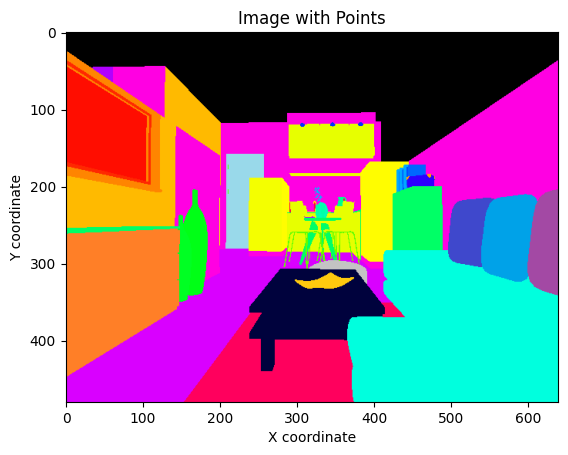

In [10]:
image = Image.open(image_path)

image_np = np.array(image)

plt.imshow(image_np)

plt.title('Image with Points')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

plt.show()

In [11]:
image_np[100, 100]

array([255, 133,   0, 255], dtype=uint8)